In [1]:
!pip install -q pyannote.audio pyannote.core

import torch
import numpy as np
import pandas as pd
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import umap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pyannote.audio.utils.signal import Binarize, Peak
from pyannote.core import Segment, notebook, SlidingWindowFeature, timeline, Timeline
from IPython.display import clear_output
import soundfile as sf
import librosa
from sklearn.cluster import KMeans, SpectralClustering
from skimage.measure import block_reduce
import seaborn as sns
from pydub import AudioSegment
from random import seed, shuffle

C:\Users\MrBrito\miniconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
###Sentences paths###
raw='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Full_Readings\\raw'

seedno=1
samptype = 'concat hellos'
#samptype = 'long recording'
#samptype = 'toy'

if samptype == 'long recording':
    dataloc='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Full_Readings\\downsamp'
elif samptype == 'concat hellos':
    dataloc=os.path.join('C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Hellos\\concat_samp\\', str(seedno))
elif samptype == 'toy':
    dataloc= 'C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Full_Readings\\toy_downsamp'

#Specify path to codec exe used by pydub
AudioSegment.converter='C:\\Users\\MrBrito\\Documents\\ffmpeg\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\bin\\ffmpeg.exe'


# speech activity detection model trained on AMI training set
sad = torch.hub.load('pyannote/pyannote-audio', 'sad_ami')
# speaker change detection model trained on AMI training set
scd = torch.hub.load('pyannote/pyannote-audio', 'scd_ami')
# speaker embedding model trained on AMI training set
emb = torch.hub.load('pyannote/pyannote-audio', 'emb_ami')

C:\Users\MrBrito\miniconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
C:\Users\MrBrito\miniconda3\lib\site-packages\pyannote\audio\embedding\approaches\arcface_loss.py:170: FutureWarning: The 's' parameter is deprecated in favor of 'scale', and will be removed in a future release
  warnings.warn(msg, FutureWarning)


In [ ]:
#seedno=1
#seed(seedno)
#samples= []
#for filename in os.listdir(directory):
#    if filename.endswith(".wav"):
#        samples.append(filename[0:4])

#samples = np.reshape(samples, (17,30))
#[shuffle(f) for f in samples[:]]
#samples = np.reshape(samples, (17,10,3))

#for f in samples[:][:]:
#    for i in f:
#        clear_output(wait=True)
#        first = AudioSegment.from_wav(os.path.join(directory, i[0]+'.wav'))
#        second = AudioSegment.from_wav(os.path.join(directory, i[1]+'.wav'))
#        third = AudioSegment.from_wav(os.path.join(directory, i[2]+'.wav'))
#       concat = first + second + third
#        concat.export(os.path.join(dataloc,i[0]+'_'+i[1] + '_' + i[2]+'.wav'), format="wav")
#        print("Processing" + i[0]+'_'+i[1] + '_' + i[2])

In [255]:
def downsamp_audio(directory):

    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            clear_output(wait=True)
            new_rate = 16000
            resamp, rate = librosa.load(os.path.join(raw, filename), sr=new_rate)
            sf.write(os.path.join(directory, filename), resamp, new_rate)
            print("processing" + str(filename))

In [237]:
def extract_embeddings(datalocation, samptype, save_dir, save_name, save=False):

    #extracts embeddings from wav files in a folder
    #does speaker activity and change detection for long sentences, but just embedding extraction for concatenated hellos

    X, sid_per_sample, sid, inter = [], [], [], []

    print("Started")
    for filename in os.listdir(dataloc):
        if filename.endswith(".wav"): 
            clear_output(wait=True)
            one_file = {'uri': 'filename', 'audio': os.path.join(dataloc, filename)}

            # obtain raw embeddings (as `pyannote.core.SlidingWindowFeature` instance)
            embeddings = emb(one_file)

            if samptype == 'concat hellos':
                #X.append(np.mean(embeddings, axis=0))
                X.append(embeddings.data)
                for i in range(0, embeddings.data.shape[0]):
                    sid_per_sample.append(filename[0:2])

            elif samptype == 'long recording' or samptype == 'toy':            
                # obtain raw SAD scores (as `pyannote.core.SlidingWindowFeature` instance), binarize raw SAD scores
                # NOTE: both onset/offset values were tuned on AMI dataset. you might need to use different values for better results
                sad_scores = sad(one_file)
                binarize = Binarize(offset=0.52, onset=0.52, log_scale=True, min_duration_off=0.1, min_duration_on=0.1)
                speech = binarize.apply(sad_scores, dimension=1)

                # obtain raw SCD scores (as `pyannote.core.SlidingWindowFeature` instance), detect peaks & return speaker homogeneous segments 
                # NOTE: both alpha/min_duration values were tuned on AMI dataset. you might need to use different values for better results.
                scd_scores = scd(one_file)
                peak = Peak(alpha=0.10, min_duration=0.10, log_scale=True)

                # speech turns are simply the intersection of SAD and SCD
                partition = peak.apply(scd_scores, dimension=1)
                speech_turns = partition.crop(speech)

                #We only work of long (> ts) speech turns
                t = 2
                long_turns = Timeline(segments=[s for s in speech_turns if s.duration > t])

                for segment in long_turns:
                    inter = embeddings.crop(segment, 'strict')
                    #X.append(np.mean(inter, axis=0))
                    X.append(inter)
                    for i in range(0, inter.shape[0]):
                        sid_per_sample.append(filename[0:2])


            # keep track of speaker label (for later scatter plot)
            #sid_per_sample.append(filename[0:2])
            sid.append(filename[0:4])
            print("Processing" + str(filename))

    X = pd.DataFrame(np.vstack(X))
    X['part'] = sid_per_sample
    print("Done")
    
    if save:
        X.to_csv(os.path.join(save_dir, save_name))

    #outputs embeddings in a dataframe with participant labels per row
    return X

In [61]:
def resample_data(X, factor, dropNA = True):
    if dropNA:
        X = X.dropna(inplace = False)
    
    #shuffle data within participant
    X = X.groupby('part').sample(frac=1).reset_index(drop=True)
    grp = X.groupby('part')
    Xdown = np.zeros(513)
    
    #mean every FACTOR datapoints per participant, drop the carryover
    for name, features in grp:
            features = features.to_numpy(dtype = 'float32')
            downsamp = block_reduce(features[:,:-1], block_size=(factor, 1), func=np.mean, cval=np.nan)
            downsamp = np.concatenate((downsamp, np.full((downsamp.shape[0],1), name, dtype='int32')), axis = 1)
            downsamp = np.where(np.isfinite(downsamp), downsamp, pd.NA)
            Xdown = np.vstack((Xdown, downsamp)) 
    Xdown = pd.DataFrame(Xdown[1:], columns = np.append(np.arange(512)+1, 'part')).dropna()
    
    return Xdown

In [184]:
def run_tSNE(Xdown, perplexity = 30, metric="euclidean"):

    tsne = TSNE(n_components=2, perplexity=perplexity, metric=metric, init = 'pca', square_distances=True)

    X2d = pd.DataFrame(tsne.fit_transform(Xdown.iloc[:, :-1]), columns = ['dim0', 'dim1'])
    X2d['part'] = Xdown['part'].to_numpy(dtype = 'int32')
    dimreduc = 'tSNE'

    return X2d, dimreduc

#X2d['first_sample']=sid
#gmap = {1:'m', 2:'f', 3:'f', 4:'f', 5:'m', 6:'f', 7:'m', 8:'f', 9:'f', 10:'f', 11:'f', 12:'m', 13:'f', 14:'f', 15:'m', 16:'f', 18:'f'}
#X2d['gender'] = X2d.index.map(gmap)
#gendercolor = [(0.41568627450980394, 0.23921568627450981, 0.6039215686274509), (0.2, 0.6274509803921569, 0.17254901960784313)]
#gcmap = {'m':gendercolor[0], 'f': gendercolor[1]}
#X2d['gcol'] = X2d.gender.map(gcmap)
#X2d['clusterSC'] = SpectralClustering(n_components=np.size(sid)).fit_predict(X2d)

def run_umap(X=None, y=None, method = 'unsupervised', scaler=None, neighbor = 10, dist=0.1, metric='correlation', 
             color_code = None, annotate_names = None, annotate = False, test_set = True, title=None, 
             savefig_path = False, X_test=None, y_test=None, color_code_test = None, plot=True, plot_centroid_names = True):
    
    dimreduc = 'UMAP'
    #reducer = umap.UMAP(n_components=dimension, n_neighbors = neighbor, min_dist=dist,metric=metric,random_state=seed_value) #, TSNE(n_components=k, random_state=seed_value), PCA(n_components=k, random_state=seed_value)]
    reducer = umap.UMAP()
    reducer_name = 'umap' #, 'tsne', 'pca']

    #pipeline = Pipeline([
    #    ('normalization', scaler),
    #    ('reducer', reducer), ])

    y_encoded = LabelEncoder().fit_transform(y)
    if method == 'supervised':
        X_reduced = reducer.fit_transform(X, y_encoded)
    elif method == 'metric_learning':
        X_reduced = reducer.fit_transform(X, y_encoded)
        X_reduced_test = reducer.transform(X_test)
        
    elif method == 'unsupervised':
        X_reduced = reducer.fit_transform(X)

    # find centroids and labels
    data = pd.DataFrame(X_reduced, columns = ['dim0', 'dim1'])
    data['label'] = y

    centers = []
    centers_labels = list(np.unique(y).astype('int32'))
    for sr in centers_labels:
        data_sr = data[data.label==sr]
        sr_centroid = data_sr[['dim0','dim1']].mean(axis=0)
        centers.append(sr_centroid)
    
    centers = np.array(centers)
    
    data.drop('label', axis=1, inplace = True)
    # Plot in 2D
    #if plot:
    #    assert dimension == 2 
    #    if method == 'metric_learning':
            # train: first time point
            #scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = 'First time step (train set)', savefig_path = savefig_path )
    #        scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = 'First time step (train set)')
            # test: next time points            
            #scatter_plot(X_reduced_test, y_test, color_code_test, method, annotate = annotate, title = title, savefig_path = savefig_path)
    #        scatter_plot(X_reduced_test, y_test, color_code_test, method, annotate = annotate, title = title)
            
    #    else:
    #        scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = title, savefig_path = savefig_path, centers=centers, centers_labels = centers_labels,plot_centroid_names = plot_centroid_names )
    if method == 'metric_learning':
        return data, pd.DataFrame(X_reduced_test, columns = ['dim0', 'dim1']), centers, centers_labels
    else:
        return data, centers, centers_labels#, dimreduc

In [195]:
def gen_color_code(X2d):
    colors = sns.color_palette("Paired", len(X2d.part.unique()))
    colors[13:]=sns.color_palette("hls")
    cmap = {}
    [cmap.update({z:colors[z]}) for z in np.array(X2d.part.unique(), dtype = 'int32')]
    colors[10] = (0,0,0)

    #X2d['c_clust'] = X2d.clusterSC.map(cmap)
    X2d['c_part'] = [colors[z-1] for z in X2d['part']]
    
    return X2d, colors
    
def plot_2Ddata(X2d, dimreduc, samptype, colors):
    fig, ax = plt.subplots(1, figsize=(9,7))
    #for x, y, w, t in zip(X2d.dim0, X2d.dim1, X2d.first_sample, X2d.index):
    for x, y, t in zip(X2d.dim0, X2d.dim1, X2d.part):
        #plt.text(x, y, w, color=colors[t-1], fontsize=10)
        plt.text(x, y, str(t), color=colors[t-1], fontsize=10)
    plt.scatter(X2d.dim0, X2d.dim1, c='1', alpha = 0.6, s=10)
    if dimreduc == 'tSNE':
        plt.title("Plot of participant using tSNE, perplexity=" + str(per) + ", with metric=" + met + ", for " + samptype)
    elif dimreduc == 'UMAP':
        plt.title("Plot of participant using UMAP for " + samptype)
    plt.show()

def plot_haus_heatmap(haus_matrix, samptype):    
    # Generate a mask for the upper triangle for each
    mask = np.triu(np.ones_like(haus_matrix, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    ax.xaxis.set_ticks_position("top")

    # Generate a custom diverging colormap
    hmapcol = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(haus_matrix, mask=mask, cmap=hmapcol, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title("Hausdorff distances between centroids of participants, for" + samptype, y = 1.08,fontsize=12)

#fig, ax = plt.subplots(1, figsize=(10,8))
#for x, y, t, g in zip(X2d.dim0, X2d.dim1, X2d.index, X2d.gcol):
#    plt.text(x, y, str(t), color=g, fontsize=10)
#plt.scatter(X2d.dim0, X2d.dim1, c='1', alpha = 0.6, s=10)
#plt.title("Plot of participant by perceived gender" + str(seedno))
#plt.show()

In [6]:
from scipy.spatial.distance import directed_hausdorff, euclidean


def hausdorff_distances(X,y, labels):
    # directed or assymetric variant     
    len_labels = len(labels)
    # build empty df
    pairwise_distances_hausdorff = pd.DataFrame(np.zeros((len_labels, len_labels)) , columns = labels, index=labels)
    # pairwise_distances_euclidean = pd.DataFrame(np.zeros((len_labels, len_labels)) , columns = labels, index=labels)                          

    # Build df out of X
    df = pd.DataFrame(X)
    df.columns = ['x1', 'x2']
    df['label'] = y

    # Compute pairwise distance between labelled arrays 
    for row in range(len_labels):
        for col in range(len_labels):
            clear_output(wait=True)
            label_a = labels[row]
            label_b = labels[col]
            label_a_values = df[df.label==label_a][['x1','x2']].values
            label_b_values = df[df.label==label_b][['x1','x2']].values
            dist_hausdorff = directed_hausdorff(label_a_values,label_b_values)
            pairwise_distances_hausdorff.iloc[row,col]= dist_hausdorff[0]
            print("Processing row " + str(row) + ", col " + str(col))
    #         dist_euclidean = euclidean(label_a_values.mean(axis=0),label_b_values.mean(axis=0))
    #         pairwise_distances_euclidean.iloc[row,col]= dist_euclidean


    return pairwise_distances_hausdorff

In [112]:
def get_cluster_data(x, datasetname, factor, resample=True, plot=True):
    #hellos2D_tsne = run_tSNE(hdown.drop('part', axis=1), perplexity = 30, metric = "euclidean")
    #sent2D_tsne = run_tSNE(sdown.drop('part', axis=1), perplexity = (len(sentdown.index)//10), metric="euclidean")
    
    if resample:
        xdown = resample_data(x, factor)
    else:
        xdown = x
    
    #run UMAP on xdown
    x2d, centers, center_labels = run_umap(X=xdown.drop('part', axis=1), y = xdown['part'], method = 'unsupervised', plot=False)
    dimreduc = 'UMAP'
    x2d['part'] = xdown['part'].to_numpy(dtype = 'int32')
    x2d, colors = gen_color_code(x2d)
    
    if plot:
        plot_2Ddata(x2d, dimreduc, 'hellos', colors)
    
    return {datasetname:{'data_2D': x2d, 'centers':centers, 'center_labels':center_labels, 'colors': colors, 'data_resamp': xdown}}


In [49]:
#outdir = 'C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis'
#outfile = 'hellos_emb.csv'
#hellos_emb = extract_embeddings()

loc = 'C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\vowel_identity\\embeddings'
hellos_emb = 'hellos.csv'
long_emb = 'sentences.csv'
#samptype = 'concat hellos'
#samptype = 'long recording'

#load already extracted embeddings as dictionary of dataframes
all_data = {os.path.splitext(f)[0]:pd.read_csv(os.path.join(loc, f), index_col=0) for f in os.listdir(loc)}

In [114]:
factors = {'hellos': 3, 'sentences': 5}
#for dataset in all_data:
#    x2d, x_centers, x_labels, x_colors = get_cluster_data(all_data[dataset], dataset, factors[dataset])

cluster_data = [get_cluster_data(all_data[dataset], dataset, factors[dataset], plot=False) for dataset in all_data]

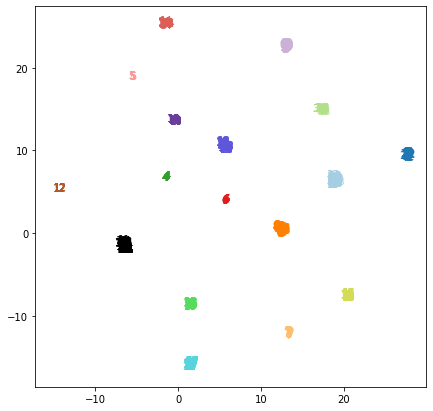

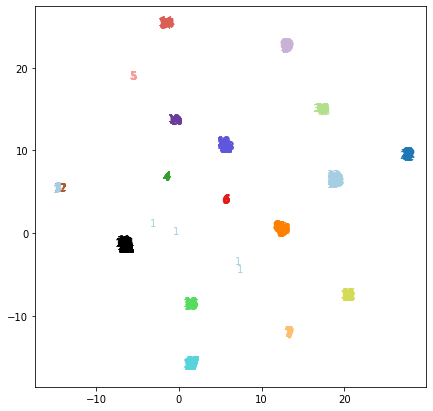

In [185]:
toRemove = 1
#X = h_down.iloc[:, :-1][h_down.part != toRemove]
#y = h_down['part'][h_down.part != toRemove]

#X_test = h_down.iloc[:, :-1][h_down.part == toRemove]
#y_test = h2d['part'][h2d.part == toRemove]

which = 'sentences'
base = cluster_data[1][which]['data_resamp']

X = base[base.part != toRemove].drop('part', axis=1)
y = base['part'][base.part != toRemove]

X_test = base[base.part == toRemove].drop('part', axis=1)
y_test = base['part'][base.part == toRemove]


#h_reduced, h_test = run_umap(X=X, y=y, method='metric_learning', color_code = h_colors, X_test=X_test, y_test=y_test, color_code_test=h_colors, plot=True)
reduced, test, reduced_centers, reduced_centers_labels = run_umap(X=X, y=y, method='metric_learning', X_test=X_test, y_test=y_test, plot=False)
reduced['part'] = y.to_numpy(dtype = 'int32')
test['part'] = y_test.to_numpy(dtype = 'int32')

fig1, ax = plt.subplots(1, figsize=(7,7))

for a, b, t in zip(reduced.dim0, reduced.dim1, reduced.part):
    plt.text(a, b, str(t), color=cluster_data[1][which]['colors'][t-1], fontsize=10)
plt.scatter(reduced.dim0, reduced.dim1, c='1', alpha = 0.6, s=10)
plt.show()

fig2, ax = plt.subplots(1, figsize=(7,7))
for a, b, t in zip(reduced.dim0, reduced.dim1, reduced.part):
    plt.text(a, b, str(t), color=cluster_data[1][which]['colors'][t-1], fontsize=10)
plt.scatter(reduced.dim0, reduced.dim1, c='1', alpha = 0.6, s=10)
for a, b, t in zip(test.dim0, test.dim1, test.part):
    plt.text(a, b, str(t), color=cluster_data[1][which]['colors'][t-1], fontsize=10)
plt.scatter(test.dim0, test.dim1, c='1', alpha = 0.6, s=10)
plt.show()


In [186]:
#haus = hausdorff_distances(X2d.iloc[:, :2], X2d['part'], X2d['part'])
#haus_h = hausdorff_distances(h_centers, h_center_labels, h_center_labels)
#haus_s = hausdorff_distances(s_centers, s_center_labels, s_center_labels)

haus_all = hausdorff_distances(cluster_data[1][which]['centers'][1:,:], cluster_data[1][which]['center_labels'][1:], cluster_data[1][which]['center_labels'][1:])
haus_less = hausdorff_distances( reduced_centers, reduced_centers_labels,  reduced_centers_labels)

#pd.concat([test, reduced])

Processing row 16, col 16


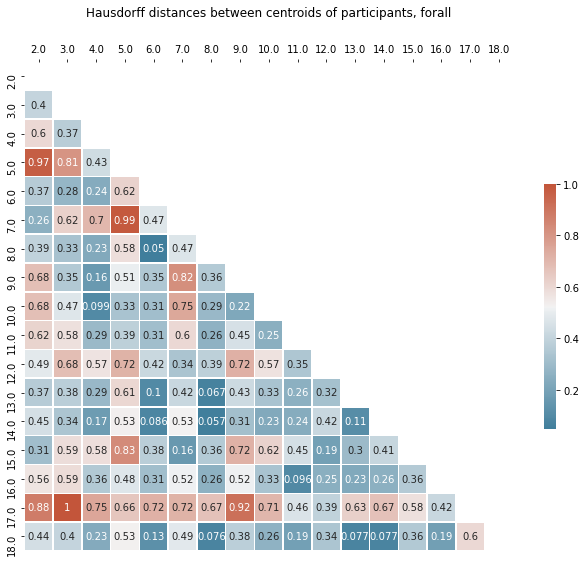

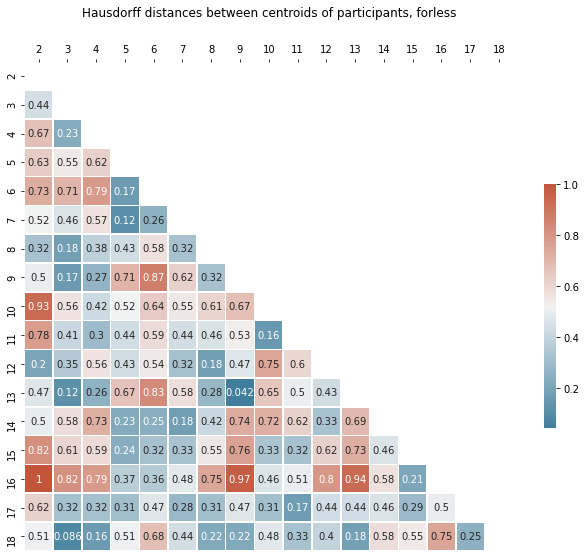

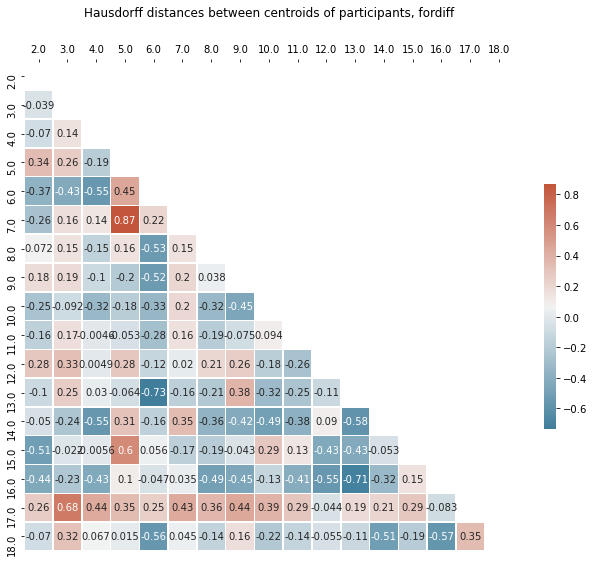

In [196]:
#plot_haus_heatmap(haus_h, 'hellos')
#plot_haus_heatmap(haus_s, 'sentences')

haus_all_norm = haus_all/haus_all.to_numpy().max()
haus_less_norm = haus_less/haus_less.to_numpy().max()

plot_haus_heatmap(haus_all_norm, 'all')
plot_haus_heatmap(haus_less_norm, 'less')

plot_haus_heatmap(haus_all_norm-haus_less_norm, 'diff')

In [163]:
comp = haus_all-haus_less
s = comp.unstack()
so = s.sort_values(kind="quicksort")
so = so[so!=0] #drop rows where samples have 0 distance (comparing the same sample)
so

14.0  4.0    -32.857274
4.0   14.0   -32.857274
      10.0   -31.301168
10.0  4.0    -31.301168
8.0   14.0   -28.312037
                ...    
9.0   7.0     18.371638
      17.0    19.104653
17.0  9.0     19.104653
      3.0     20.481941
3.0   17.0    20.481941
Length: 272, dtype: float64

In [ ]:
#reducer=umap.UMAP()
#X2d =pd.DataFrame(reducer.fit_transform(Xdown.iloc[:, :-1]), columns = ['dim0', 'dim1'])
#X2d['part'] = Xdown['part'].to_numpy(dtype = 'int32')

#fig, ax = plt.subplots(1, figsize=(10,8))
#for x, y, w, t in zip(X2d.dim0, X2d.dim1, X2d.first_sample, X2d.index):
#for x, y, t in zip(X2d.dim0, X2d.dim1, X2d.part):
    #plt.text(x, y, w, color=colors[t-1], fontsize=10)
#    plt.text(x, y, str(t), color=colors[t-1], fontsize=10)
#plt.scatter(X2d.dim0, X2d.dim1, c='1', alpha = 0.6, s=10)
#plt.title("Plot of participant using UMAP for " + samptype)
#plt.show()

# plot 
#fig, ax = plt.subplots()
#fig.set_figheight(7.5)
#fig.set_figwidth(7.5)
#plt.legend(y_true[:120], loc='center left', bbox_to_anchor=(1.0, 0.75))
#plt.scatter(*X_2dU.T, c=y_true)
#plt.scatter(*X_2dU[:n,:].T, c=y_true[:n])


In [145]:
# k means
kmeans = KMeans(n_clusters=len(X2d.part.unique()))
X2d['cluster'] = kmeans.fit_predict(X2d[['dim0', 'dim1']])

# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to tSNE cluster pd
xmap = {}
ymap = {}
[xmap.update({z:cen_x[z]}) for z in np.arange(len(cen_x))]
[ymap.update({z:cen_y[z]}) for z in np.arange(len(cen_y))]
X2d['cen_x'] = X2d.cluster.map(xmap)
X2d['cen_y'] = X2d.cluster.map(ymap)

#define and map colors
#based on cluster
colors = sns.color_palette("Paired", len(X2d.part.unique())+2)
cmap = {}
[cmap.update({z:colors[z]}) for z in np.arange(len(cen_x))]
X2d['c_clust'] = X2d.cluster.map(cmap)
#X2d['c_part'] = [colors[z] for z in X2d.part.unique()]

In [ ]:
specclus = SpectralClustering(n_clusters=len(X2d.part.unique()))
X2d['cluster'] = specclus.fit_predict(X2d[['dim0', 'dim1']])


In [ ]:
# plot 
fig, ax = plt.subplots(1, figsize=(11,9))

#plot data
#plt.scatter(X2d.dim0, X2d.dim1, c=X2d.c_part, alpha = 0.6, s=10)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
#plt.legend(handles=legend_elements, bbox_to_anchor=(1.2, 1), loc='upper right')
#plt.title('tSNE plot of clusters\n', loc='left', fontsize=22)

for x, y, t in zip(X2d.dim0, X2d.dim1, X2d.part):
#    plt.text(x, y, str(t), color=colors[t], fontsize=12)
    plt.scatter(x, y, color=colors[t-1])

#plot centroids
plt.scatter(cen_x, cen_y, marker='^', c='k', s=100)

#plot distances
for idx, val in X2d.iterrows():
    x = [val.dim0, val.cen_x,]
    y = [val.dim1, val.cen_y]
    #plt.plot(x, y, c=val.c_clust, alpha=0.2)
    #plt.plot(x, y, c='0.4', alpha=0.2)

plt.title("Plot of participant using UMAP for " + samptype + "with kmeans centroids")
plt.show()